# Capstone 1: Machine Learning Algorithms - Baseline

<a id='TOC'></a>
**Table of Contents**
1. Preliminaries
    1. [Import EMS Incident Data](#Sec01A)
    2. [Preprocess Dataset](#Sec01B)
    3. [Segment Variables](#Sec01C)
2. Variable Encoding Methods
    1. [Inspect Target Variable](#Sec02A)
    2. [One-Hot Encoding](#Sec02B)
    3. [Binary Encoding](#Sec02C)
3. Baseline Model
    1. [Logistic Regression](#Sec03A)
    2. [Analysis of Model Performance](#Sec03B)

The goal of this project is to develop machine learning models that predict whether or not the outcome of an EMS incident will result in a fatality. This is a supervised, binary classification problem. Analyses will be performed on a collection of nearly 8 million records of documented incidents, which span the six year period from January 2013 through December 2018, and appropriate predictive models will be developed to achieve the primary objective. This dataset is robust and contains several feature variables, of mixed data types, that describe both various attributes of each incident as well as the responsive action taken by the FDNY. All of the aforementioned factors affect an individual’s survivability once a response is initiated.

The dataset will be preprocessed using insights gained through prior analyses and various encoding methods for categorical variables. Afterwards, baseline classifiers will be constructed and assessed for their model performance on both training and test data.

## 1. PRELIMINARIES

<a id='Sec01A'></a>
#### 1A: Import EMS incident data

In [1]:
# Import packages and modules
import pandas as pd
import numpy as np
import category_encoders as ce

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression

In [2]:
# Assign file path
file_path = '../data/clean_EMS_data.csv'

# Read CSV data into a Pandas DataFrame
datetime_cols = ['incident_datetime',
                 'first_assignment_datetime',
                 'first_activation_datetime',
                 'first_on_scene_datetime',
                 'first_to_hosp_datetime',
                 'first_hosp_arrival_datetime',
                 'incident_close_datetime']

df = pd.read_csv(file_path,compression='gzip',
                 parse_dates=datetime_cols,
                 index_col=['incident_datetime'])

In [3]:
df.info(verbose=True,memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7988028 entries, 2013-01-01 00:00:04 to 2018-12-19 00:19:39
Data columns (total 29 columns):
year                           int64
month                          int64
day                            int64
hour                           int64
weekday                        int64
borough                        object
zipcode                        float64
latitude                       float64
longitude                      float64
aland_sqmi                     float64
awater_sqmi                    float64
initial_call_type              object
initial_severity_level         int64
final_call_type                object
final_severity_level           int64
held_indicator                 object
first_assignment_datetime      datetime64[ns]
incident_dispatch_area         object
dispatch_time                  int64
first_activation_datetime      datetime64[ns]
first_on_scene_datetime        datetime64[ns]
travel_time                    floa

[TOC](#TOC)

<a id="Sec01B"></a>
#### 1B: Preprocess Dataset

In [4]:
# Change dtypes
df['borough'] = df.borough.astype('category')
df['zipcode'] = df.zipcode.astype('category')

Both exploratory data analysis and inferential statistics performed in prior notebooks ([CP1-02_EDA](https://github.com/jdwill917/SB-DSCT-Repo/blob/master/Capstones/Capstone%201/code/CP1-02_EDA.ipynb) and [CP1-03_Stats](https://github.com/jdwill917/SB-DSCT-Repo/blob/master/Capstones/Capstone%201/code/CP1-03_Stats.ipynb), respectively) revealed there are multiple redundant or immaterial variables within the dataset. Therefore, they will be removed from the dataset.

In [5]:
# Remove immaterial columns
list_of_cols = ['latitude','longitude',
                'aland_sqmi','awater_sqmi','held_indicator',
                'initial_call_type','initial_severity_level',
                'first_assignment_datetime','incident_dispatch_area',
                'dispatch_time','travel_time',
                'first_activation_datetime','first_on_scene_datetime',
                'first_to_hosp_datetime','first_hosp_arrival_datetime',
                'incident_close_datetime','incident_disposition_code']
df.drop(list_of_cols,axis=1,inplace=True)

In [6]:
df.info(verbose=True,memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7988028 entries, 2013-01-01 00:00:04 to 2018-12-19 00:19:39
Data columns (total 12 columns):
year                    int64
month                   int64
day                     int64
hour                    int64
weekday                 int64
borough                 category
zipcode                 category
final_call_type         object
final_severity_level    int64
response_time           float64
life_threatening        bool
fatality                bool
dtypes: bool(2), category(2), float64(1), int64(6), object(1)
memory usage: 997.4 MB


In [7]:
df.head()

,year,month,day,hour,weekday,borough,zipcode,final_call_type,final_severity_level,response_time,life_threatening,fatality
incident_datetime,,,,,,,,,,,,
2013-01-01 00:00:04,2013,1,1,0,2,BRONX,10472.0,RESPIR,4,797.0,False,False
2013-01-01 00:05:52,2013,1,1,0,2,BRONX,10472.0,EDP,7,534.0,False,False
2013-01-01 00:20:37,2013,1,1,0,2,BRONX,10472.0,SICK,6,697.0,False,False
2013-01-01 01:53:11,2013,1,1,1,2,BRONX,10472.0,INJURY,4,223.0,False,False
2013-01-01 01:54:28,2013,1,1,1,2,BRONX,10472.0,SICK,4,298.0,False,False


The clean dataset is now comprised of eleven feature variables that will be used in the development of ML algorithms. [TOC](#TOC)

<a id="Sec01C"></a>
#### 1C: Segment Feature Variables

In [8]:
# Numeric feature variables
var_names_num = ['year','month','day','hour','weekday','response_time']
vars_num = df[var_names_num]

# Ordinal feature variables
var_names_ord = ['final_severity_level','life_threatening']
vars_ord = df[var_names_ord]

# Nominal feature variables
var_names_nom = ['borough','zipcode','final_call_type']
vars_nom = df[var_names_nom]

In [9]:
# Print count of labels for each ordinal feature variable
print('COUNT OF ORDINAL FEATURE LABELS\n')
for col in vars_ord.columns:
    print('{0:21}: {1} labels'.format(col,len(vars_ord[col].unique())))
print('\n')

# Print count of labels for each nominal feature variable
print('COUNT OF NOMINAL FEATURE LABELS\n')
for col in vars_nom.columns:
    print('{0:16}: {1:3} labels'.format(col,len(vars_nom[col].unique())))

COUNT OF ORDINAL FEATURE LABELS

final_severity_level : 8 labels
life_threatening     : 2 labels


COUNT OF NOMINAL FEATURE LABELS

borough         :   6 labels
zipcode         : 208 labels
final_call_type : 135 labels


Few machine learning algorithms perform well with categorical variables. Thus, such values will have to be encoded as numeric types. Two of the five categorical feature variables (`zipcode` and `final_call_type`) have a high cardinality as indicated above. In the next section, different encoding methods will be applied to the dataset and tested with different baseline models. [TOC](#TOC)

***

## 2. VARIABLE ENCODING METHODS

<a id="Sec02A"></a>
#### 2A: Inspect Target Variable

In [10]:
df['fatality'].value_counts()

False    7649344
True      338684
Name: fatality, dtype: int64

In [11]:
df['fatality'].value_counts(normalize=True)

False    0.957601
True     0.042399
Name: fatality, dtype: float64

The target variable is segmented into two classes: __fatalities__ (`fatality == True`) and __survivals__ (`fatality == False`). Based on the frequency values provided above, it is clear that __fatalities__ represent the *minority* class whereas __survivals__ represent the *majority* class. Whether or not this will have an impact on the effectiveness of baseline model has yet to be determined. [TOC](#TOC)

<a id="Sec02B"></a>
#### 2B: One-Hot Encoding

In [12]:
# One-Hot encode dataframe
df_ohe = pd.get_dummies(df,prefix=['brgh','zip','fct'])

# Inspect encoded dataframe
print(df_ohe.shape)
df_ohe.head()

(7988028, 358)


,year,month,day,hour,weekday,final_severity_level,response_time,life_threatening,fatality,brgh_BRONX,...,fct_STAB,fct_STATEP,fct_STATFC,fct_TRAUMA,fct_UNC,fct_UNCFC,fct_UNCFT,fct_UNCRF,fct_UNKNOW,fct_VENOM
incident_datetime,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:04,2013,1,1,0,2,4,797.0,False,False,1,...,0,0,0,0,0,0,0,0,0,0
2013-01-01 00:05:52,2013,1,1,0,2,7,534.0,False,False,1,...,0,0,0,0,0,0,0,0,0,0
2013-01-01 00:20:37,2013,1,1,0,2,6,697.0,False,False,1,...,0,0,0,0,0,0,0,0,0,0
2013-01-01 01:53:11,2013,1,1,1,2,4,223.0,False,False,1,...,0,0,0,0,0,0,0,0,0,0
2013-01-01 01:54:28,2013,1,1,1,2,4,298.0,False,False,1,...,0,0,0,0,0,0,0,0,0,0


In [13]:
# Target variable
y_ohe = df_ohe['fatality'].values
print('y\nType: {0}\nShape: {1}\n'.format(type(y_ohe),y_ohe.shape))

# All feature variables
X_tmp = df_ohe.drop(columns=['fatality'])
X_ohe = X_tmp.values
print('X (One-Hot Encoding)\nType: {0}\nShape: {1}'.format(type(X_ohe),X_ohe.shape))

y
Type: <class 'numpy.ndarray'>
Shape: (7988028,)

X (One-Hot Encoding)
Type: <class 'numpy.ndarray'>
Shape: (7988028, 357)


Applying One-Hot encoding increases the number of feature variables in the clean dataset from 11 to 357. [TOC](#TOC)

<a id="Sec02C"></a>
#### 2C: Binary Encoding

In [14]:
# Binary encode dataframe
enc_binary = ce.BinaryEncoder(cols=var_names_nom)
df_bin = enc_binary.fit_transform(df)

# Inspect encoded dataframe
print(df_bin.shape)
df_bin.head()

(7988028, 31)


,year,month,day,hour,weekday,borough_0,borough_1,borough_2,borough_3,zipcode_0,...,final_call_type_3,final_call_type_4,final_call_type_5,final_call_type_6,final_call_type_7,final_call_type_8,final_severity_level,response_time,life_threatening,fatality
incident_datetime,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:04,2013,1,1,0,2,0,0,0,1,0,...,0,0,0,0,0,1,4,797.0,False,False
2013-01-01 00:05:52,2013,1,1,0,2,0,0,0,1,0,...,0,0,0,0,1,0,7,534.0,False,False
2013-01-01 00:20:37,2013,1,1,0,2,0,0,0,1,0,...,0,0,0,0,1,1,6,697.0,False,False
2013-01-01 01:53:11,2013,1,1,1,2,0,0,0,1,0,...,0,0,0,1,0,0,4,223.0,False,False
2013-01-01 01:54:28,2013,1,1,1,2,0,0,0,1,0,...,0,0,0,0,1,1,4,298.0,False,False


In [15]:
# Target variable
y_bin = df_bin['fatality'].values
print('y\nType: {0}\nShape: {1}\n'.format(type(y_bin),y_bin.shape))

# All feature variables
X_bin = df_bin.iloc[:,:-1].values
print('X (Binary Encoding)\nType: {0}\nShape: {1}'.format(type(X_bin),X_bin.shape))

y
Type: <class 'numpy.ndarray'>
Shape: (7988028,)

X (Binary Encoding)
Type: <class 'numpy.ndarray'>
Shape: (7988028, 30)


Applying binary encoding increases the number of feature variables in the clean dataset from 11 to 30. [TOC](#TOC)

***

## 3. Baseline Model

<a id="Sec03A"></a>
#### 3A: Logistic Regression

In [16]:
# # Split the One-Hot encoded data into a training and test set
# X_train, X_test, y_train, y_test = train_test_split(X_ohe, y_ohe, test_size=0.25, random_state=716)

In [17]:
# Split the binary encoded data into a training and test set
X_train, X_test, y_train, y_test = train_test_split(X_bin, y_bin, test_size=0.25, random_state=1025)

In [18]:
# Instantiate a baseline logistic regression model
lr = LogisticRegression(max_iter=10000)

# Fit the model to the binary encoded dataset
lr.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

[TOC](#TOC)

<a id="Sec03B"></a>
#### 3B: Analysis of Model Performance

TRAINING DATA

Accuracy score: 0.9575 (ylr, y_predict_training)


Classification Report:
              precision    recall  f1-score   support

       False       0.96      1.00      0.98   5737532
        True       0.26      0.00      0.00    253489

    accuracy                           0.96   5991021
   macro avg       0.61      0.50      0.49   5991021
weighted avg       0.93      0.96      0.94   5991021



TEST DATA

Accuracy score: 0.9572 (ytestlr, y_predict_test)


Classification Report:
              precision    recall  f1-score   support

       False       0.96      1.00      0.98   1911812
        True       0.29      0.00      0.00     85195

    accuracy                           0.96   1997007
   macro avg       0.62      0.50      0.49   1997007
weighted avg       0.93      0.96      0.94   1997007



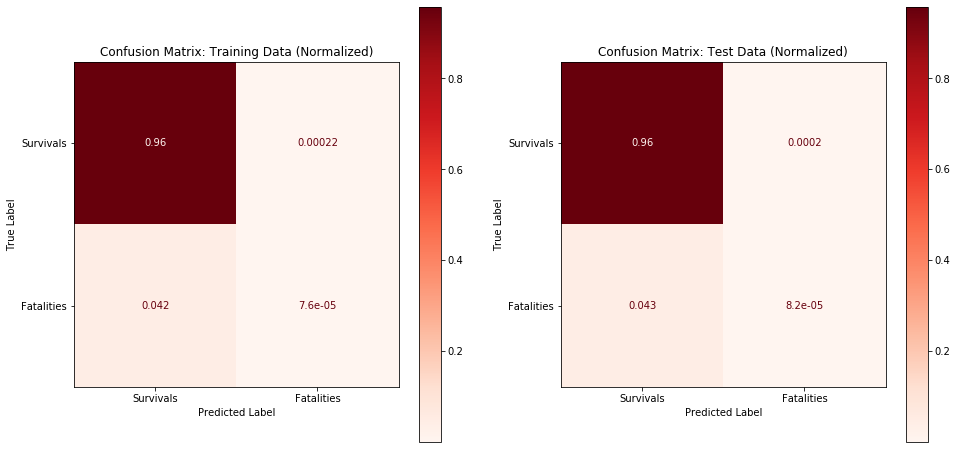

In [19]:
y_pred_training = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

# Assessment metrics for training data
print('TRAINING DATA\n')
print('Accuracy score: {:.4f} (ylr, y_predict_training)'.format(accuracy_score(y_train, y_pred_training)))
print('\n')
print('Classification Report:')
print(classification_report(y_train, y_pred_training))
print('\n')

# Assessment metrics for test data
print('TEST DATA\n')
print('Accuracy score: {:.4f} (ytestlr, y_predict_test)'.format(accuracy_score(y_test, y_pred_test)))
print('\n')
print('Classification Report:')
print(classification_report(y_test, y_pred_test))

# Normalized confusion matrix plot for training and test data
y_class_names = ['Survivals','Fatalities']

fig3B1, (ax3B1,ax3B2) = plt.subplots(1,2,figsize=(16,8),sharey=False)
disp = plot_confusion_matrix(lr,X_train,y_train,normalize='all',
                             ax=ax3B1,display_labels=y_class_names,cmap='Reds')
ax3B1.set_title('Confusion Matrix: Training Data (Normalized)')
ax3B1.set_xlabel('Predicted Label')
ax3B1.set_ylabel('True Label')

disp = plot_confusion_matrix(lr,X_test,y_test,normalize='all',
                             ax=ax3B2,display_labels=y_class_names,cmap='Reds')
ax3B2.set_title('Confusion Matrix: Test Data (Normalized)')
ax3B2.set_xlabel('Predicted Label')
ax3B2.set_ylabel('True Label')

#plt.savefig('../graphics/CP1-04a_fig03B.png') # Export confusion matrix plot to PNG file
plt.show()

It may seem that the baseline logistic regression model performs well given the metrics for both the training and test data are similar, however, this is not the case. The two classes of the target variable (`fatality`) are heavily imbalanced. The accuracy score for both the training and test sets can be attributed to the fact that the model accurately predicts the _majority_ class (__Survivals__) given its high frequency in the original dataset. Yet the recall metric clearly shows that the classifier fails to detect any observation with the _minority_ class (__Fatalities__). For this reason, a [separate notebook](https://github.com/jdwill917/SB-DSCT-Repo/blob/master/Capstones/Capstone%201/code/CP1-04b_MLA.ipynb) will be used to explore different approaches that are tailored to address imbalanced classification problems such as this one. [TOC](#TOC)